In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from my_config import CHAR_IMG_SIZE



def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def eval_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total



class CharCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CharCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, CHAR_IMG_SIZE, CHAR_IMG_SIZE)
            sample_output = self.pool3(F.relu(self.conv3(self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(sample_input))))))))) #check , if you change above, change this too
            flattened_size = sample_output.numel()

        self.fc1 = nn.Linear(flattened_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        if(x.dim() == 3):
            x = x.unsqueeze(0)
        elif(x.dim() == 2):
            x = x.unsqueeze(0).unsqueeze(0)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


if torch.mps.is_available():
    device = torch.device("mps")
    print("using mps device")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CharCNN(num_classes=36).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10




using mps device


torch.Size([32, 1, 64, 64])


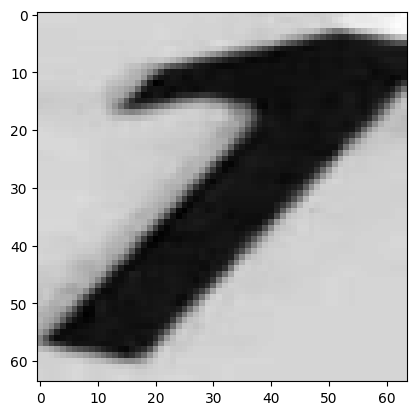

tensor([ 1, 30, 23, 11,  4, 29, 26, 20,  2, 23, 28, 25, 17, 10,  3,  2, 29,  8,
         1, 24, 20,  0,  2, 29, 24, 28, 26,  8, 14,  8, 23, 28])


In [ ]:
from my_config import char_img_transform
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# train_dataset = datasets.ImageFolder("char_dataset/train", transform=char_img_transform)
# val_dataset   = datasets.ImageFolder("char_dataset/val",   transform=char_img_transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

root = "char_dataset_alter"   # your folder with A,B,C...,0,1,2, etc.
full_dataset = datasets.ImageFolder(root, transform=char_img_transform)

# TRAIN/VAL SPLIT (80/20)
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

# MAPS: class index → "A"/"3" etc.
idx_to_char = {v: k for k, v in full_dataset.class_to_idx.items()}


In [3]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} " f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    torch.save(model.state_dict(), "char_cnn_alter_dataset.pth")


Epoch 1/10 Train Loss: 3.5818 Acc: 0.0302 | Val Loss: 3.5599 Acc: 0.0279
Epoch 2/10 Train Loss: 3.5581 Acc: 0.0298 | Val Loss: 3.5587 Acc: 0.0258
Epoch 3/10 Train Loss: 3.5580 Acc: 0.0286 | Val Loss: 3.5570 Acc: 0.0311
Epoch 4/10 Train Loss: 3.5577 Acc: 0.0277 | Val Loss: 3.5568 Acc: 0.0249


KeyboardInterrupt: 

In [7]:

import string
from PIL import Image
import cv2
INT_TO_CHAR_MAP = {idx: ch for idx, ch in enumerate('0123456789' + string.ascii_uppercase)}

def get_character_recogniser(model):


    def character_recogniser(char_img):
        prediction = torch.argmax(model(char_img_transform(Image.fromarray(char_img))), dim=-1)
        return INT_TO_CHAR_MAP.get(prediction.item(), '')
    
    return character_recogniser

character_recogniser_model = CharCNN(num_classes=36)
character_recogniser_model.load_state_dict(torch.load('char_cnn.pth'))
character_recogniser_model.eval()
character_recogniser = get_character_recogniser(character_recogniser_model)






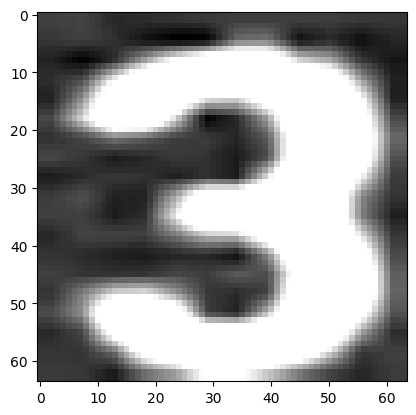

torch.Size([1, 64, 64])
3


In [ ]:

import numpy as np
char_img = cv2.imread('char_7.png', cv2.IMREAD_GRAYSCALE)
char_img_copy = char_img.copy()
if(np.max(char_img_copy)<1):
    char_img_copy = (char_img_copy*255).astype(np.uint8)
boundary_sum= (np.sum(char_img_copy[0:2])+np.sum(char_img_copy[:,0:2])+np.sum(char_img_copy[-2:])+np.sum(char_img_copy[:,-2:]))
if((boundary_sum/(4*(char_img_copy.shape[0]+char_img_copy.shape[1]))) >50):
    char_img_copy = 255-char_img_copy

print(char_img_transform(Image.fromarray(char_img_copy)).shape)
ch = character_recogniser(char_img_copy)
print(ch)


In [19]:
from statistics import median
print(median([10,30,30,-1,30,30,10]))

30


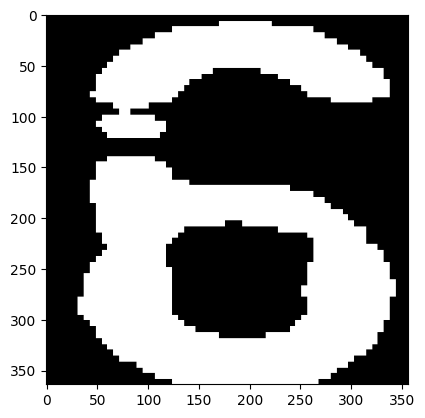

In [22]:
img = cv2.threshold(cv2.imread('car6_inter.png', cv2.IMREAD_GRAYSCALE), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(img, cmap='gray')
plt.show()